In [1]:
import numpy as np
import scipy.stats as sps

import matplotlib.pyplot as plt

## Setting the stage

In [2]:
def my_proposal(x_t):
    ''' Proposal distribution. Suggests next point given current point. '''
    x_prime = sps.norm.rvs(loc=x_t, scale=1.)
    
    return x_prime

def my_f(x):
    ''' Function that is proportional to the target distribution.
    Does not have to be normalised. '''    
    a = 3.*sps.norm.pdf(x, loc=5, scale=2)
    b = sps.norm.pdf(x, loc=2.4, scale=0.6)
    
    return a+b

def my_target(x):
    ''' Target distribution to be sampled from. This is a PDF. '''
    
    return my_f(x)/4.

# Distribution to sample the initial point from
my_prior = sps.norm(loc=4.35, scale=1.125)

## Wrapping MCMC process up into a function

In [3]:
def walker(x_t,
           n_steps=1000):
    """
    Compute one MC chain.

    Parameters
    ----------
    x_t (float): Initial point
    n_steps (int): Number of steps walker takes

    Returns
    -------
    x_bag (np.array): The MC chain
    """
    x_bag = []
    acceptance_bag = []
    for ind_step in range(n_steps):
        # Propose next point, x', given current point
        x_prime = my_proposal(x_t)
    
        # Compute acceptance ratio
        acceptance_ratio = my_f(x_prime)/my_f(x_t) # can be >=1 
        acceptance_bag.append(acceptance_ratio)
        
        # Decide if want to accept candidate point
        u = np.random.uniform(low=0, high=1)
        
        if (u<=acceptance_ratio):
            # Accepts candidate point
            x_bag.append(x_prime)
    
            # Updates 'current' point
            x_t = x_prime
            
        else:
            # Rejects candidate point, and keep the current point
            x_bag.append(x_t)

    return np.array(x_bag), np.array(acceptance_bag)

## Generating 1 chain

In [4]:
x_chain, acceptance = walker(my_prior.rvs(),
                             n_steps=int(1e4))

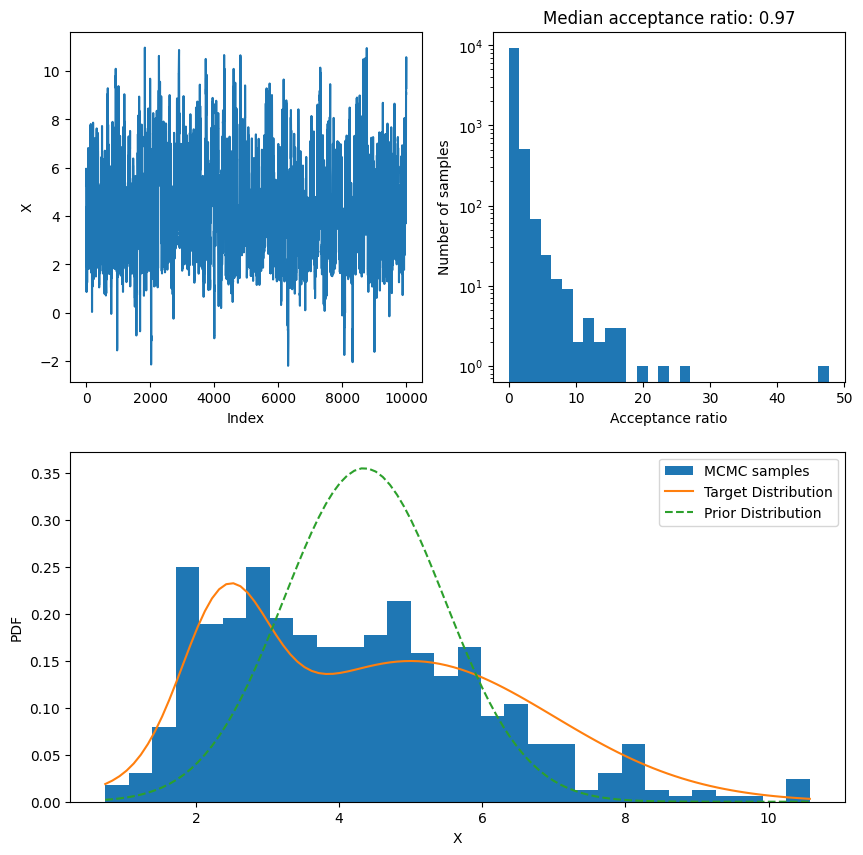

In [5]:
plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.plot(x_chain)
plt.xlabel('Index')
plt.ylabel('X')

plt.subplot(222)
plt.hist(acceptance, bins=30)
plt.xlabel('Acceptance ratio')
plt.ylabel('Number of samples')
plt.yscale('log')
plt.title(f'Median acceptance ratio: {np.median(acceptance):.2f}')

plt.subplot(212)
x_select = x_chain[-500:]
nbins = 30
xx_plot = np.linspace(min(x_select), max(x_select), 100)
plt.hist(x_select, bins=nbins, density=True, label='MCMC samples')
plt.plot(xx_plot, my_target(xx_plot), label='Target Distribution')
plt.plot(xx_plot, my_prior.pdf(xx_plot), ls='--', label='Prior Distribution')
plt.xlabel('X')
plt.ylabel('PDF')
plt.legend()

## Gelman-Rubin statistic

In [6]:
n_chains = 20
n_steps = 1000

prior_bag = []
x_bag = []
# Generating a bunch of Markov chains
for ind_chain in range(n_chains):
    _prior = my_prior.rvs()
    _chain, tmp = walker(_prior, n_steps=n_steps) # not going to save the acceptance ratio

    prior_bag.append(_prior)
    x_bag.append(_chain)

# Turn list into np.array
x_bag = np.array(x_bag) # (n_chains, n_steps)

In [7]:
def compute_GR(x):
    # Get number of chains and samples each chain has
    n_chains, n_steps = np.shape(x)
    
    # Intra-chain properties
    mean_chain = np.mean(x, axis=1) # mean of each chain
    variance_chain = np.std(x, ddof=n_chains-1, axis=1)**2 # variance within each chain
    W = np.mean(variance_chain) # Average intra-chain variance
    
    # Inter-chain properties
    overall_mean = np.mean(mean_chain) # mean of means across each chain
    B = np.std(mean_chain, ddof=n_chains-1)**2 # Variance of means of chain
    
    # Gelman-Rubin statistic
    R = ((n_steps-1)*W + B)/n_steps
    R /= W

    return R

In [8]:
gr_bag = []
for ind_step in range(n_steps):
    _x = x_bag[:,:ind_step+1]
    _R = compute_GR(_x)
    gr_bag.append(_R)
gr_bag = np.array(gr_bag)

/home/peaelle42/miniconda3/envs/py311/lib/python3.11/site-packages/numpy/_core/_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/peaelle42/miniconda3/envs/py311/lib/python3.11/site-packages/numpy/_core/_methods.py:216: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/peaelle42/miniconda3/envs/py311/lib/python3.11/site-packages/numpy/_core/_methods.py:216: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_10826/3335141275.py:16: RuntimeWarning: invalid value encountered in scalar divide
  R /= W


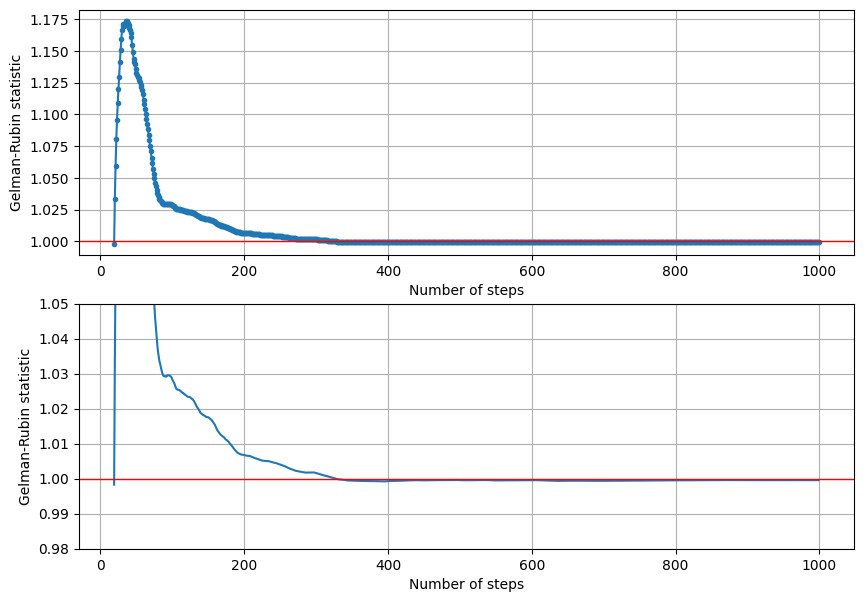

In [9]:
plt.figure(figsize=(10, 7))
plt.subplot(211)
plt.plot(gr_bag, '.-')
plt.axhline(1, color='r', lw=1)
plt.xlabel('Number of steps')
plt.ylabel('Gelman-Rubin statistic')
plt.grid()

plt.subplot(212)
plt.plot(gr_bag, '-')
plt.axhline(1, color='r', lw=1)
plt.xlabel('Number of steps')
plt.ylabel('Gelman-Rubin statistic')
plt.ylim(0.98, 1.05)
plt.grid()

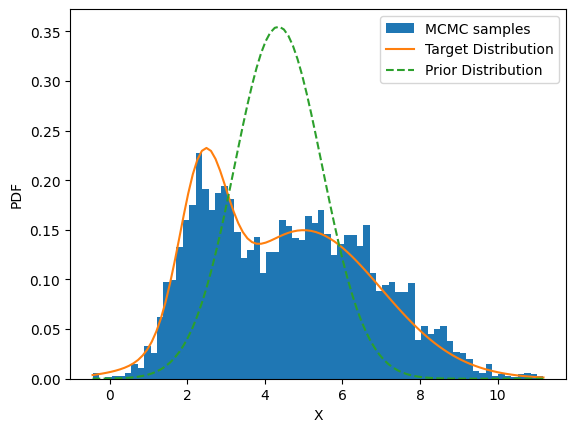

In [10]:
x_select_grand = x_bag[:,-200:].flatten()
nbins = 70
xx_plot = np.linspace(min(x_select_grand), max(x_select_grand), 100)
plt.hist(x_select_grand, bins=nbins, density=True, label='MCMC samples')
plt.plot(xx_plot, my_target(xx_plot), label='Target Distribution')
plt.plot(xx_plot, my_prior.pdf(xx_plot), ls='--', label='Prior Distribution')
plt.xlabel('X')
plt.ylabel('PDF')
plt.legend()

BAM.